### Pre-process step 4
- Extract behavior events from json file saved with bonsai
- Align behavior events to fiber photometry data from step 3
- Extract rewarded and unrewarded trials and other interesting parameters

In [1]:
import pandas as pd
import numpy as np
import os
import glob
from config import load_config
paths = load_config(dataset_key='all')
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import h5py
import json


Paths are for dataset tagged: all


In [3]:
# Load and parse json file
jsonfiles = glob.glob(os.path.join(paths['raw_data'],'*.json'))
print(jsonfiles)

behavior_jsonfile = jsonfiles[2]
with open(behavior_jsonfile) as f:
    data = json.load(f)
    print(data.keys())



['C:\\AIND\\output_data\\BigTiffs2023-07-19T11_41_07.3182208-07_00\\hsfp_rig.json', 'C:\\AIND\\output_data\\BigTiffs2023-07-19T11_41_07.3182208-07_00\\ophys_session.json', 'C:\\AIND\\output_data\\BigTiffs2023-07-19T11_41_07.3182208-07_00\\SS_674663_2023-07-19.json']
dict_keys(['TP_', 'TP_AdvancedBlockAuto', 'TP_AnimalName', 'TP_AutoReward', 'TP_AutoWaterType', 'TP_BaseRewardSum', 'TP_BiasCheck', 'TP_BlockBeta', 'TP_BlockMax', 'TP_BlockMin', 'TP_BlockMinReward', 'TP_Clear', 'TP_ConditionP_1', 'TP_ConditionP_2', 'TP_ConditionP_3', 'TP_ConditionP_4', 'TP_Condition_1', 'TP_Condition_2', 'TP_Condition_3', 'TP_Condition_4', 'TP_DelayBeta', 'TP_DelayMax', 'TP_DelayMin', 'TP_Duration_1', 'TP_Duration_2', 'TP_Duration_3', 'TP_Duration_4', 'TP_EarlyLickPulishment', 'TP_Experimenter', 'TP_ExtraWater', 'TP_Frequency_1', 'TP_Frequency_2', 'TP_Frequency_3', 'TP_Frequency_4', 'TP_GiveLeft', 'TP_GiveRight', 'TP_GiveWaterL', 'TP_GiveWaterR', 'TP_ID', 'TP_ITIBeta', 'TP_ITIIncrease', 'TP_ITIMax', 'TP_ITI

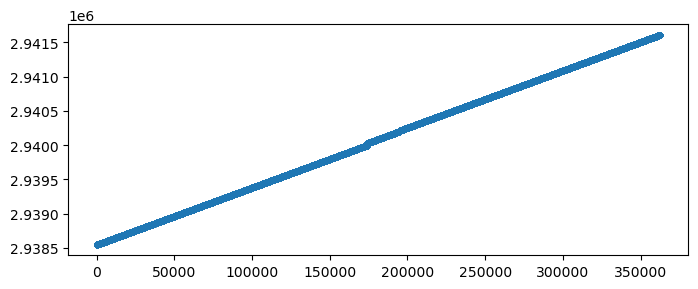

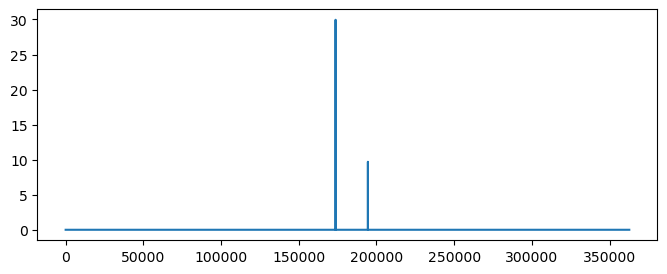

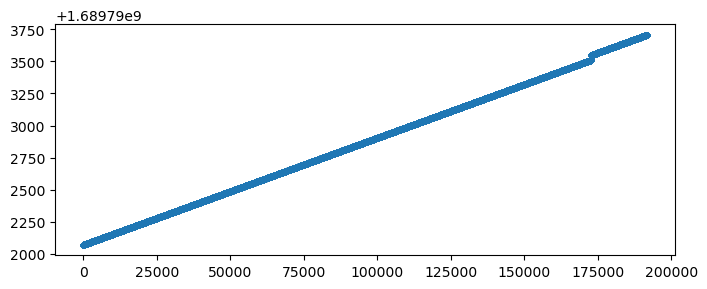

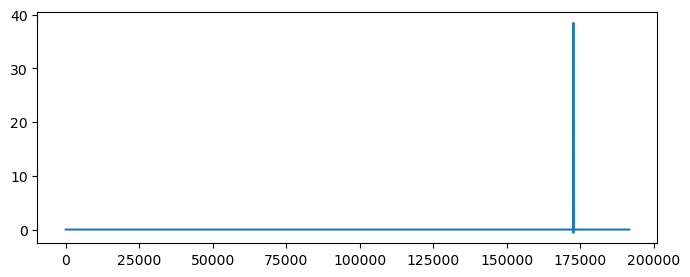

In [32]:
# Plot harp camera trigger
harp_camTrigger = data['B_CamerasTrigger']
# Plot figure with camTrigger 
plt.figure(figsize=(8,3))
plt.plot(harp_camTrigger,'.')
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(harp_camTrigger))
plt.show()

# Load HSFP preprocessed hdf5 file 
f = h5py.File(paths['raw_data'] / 'data_preprocessed.hdf5','r')
time_405 = np.array(f['Time'])
timestamps = np.array(f['Full_TimeStamps'])
lasers = np.array(f['Lasers'])
wavelength = np.array(f['Wavelength'])
L_405_F1 = np.array(f['Channel_405_F1'])
L_405_F2 = np.array(f['Channel_405_F2'])
L_445_F1 = np.array(f['Channel_445_F1'])
L_445_F2 = np.array(f['Channel_445_F2'])
L_473_F1 = np.array(f['Channel_473_F1'])
L_473_F2 = np.array(f['Channel_473_F2'])
L_514_F1 = np.array(f['Channel_514_F1'])
L_514_F2 = np.array(f['Channel_514_F2'])
L_560_F1 = np.array(f['Channel_560_F1'])
L_560_F2 = np.array(f['Channel_560_F2'])
# Plot figure with camTrigger 
plt.figure(figsize=(8,3))
plt.plot(timestamps,'.')
plt.show()
plt.figure(figsize=(8,3))
plt.plot(np.diff(timestamps))
plt.show()

In [52]:
# Make hsfp camera time and harp camera time on the same scale

# Find splits in harp camera trigger
peaks, _ = find_peaks(np.diff(harp_camTrigger), height=5)
peaks = peaks + 1
print(len(peaks))
print(peaks)

harp_times_cut = []
harp_times_cut.append(harp_camTrigger[0:peaks[0]])
for i in range(len(peaks)):
    if i == len(peaks)-1:
        harp_times_cut.append(harp_camTrigger[peaks[i]:-1])
    else:
        harp_times_cut.append(harp_camTrigger[peaks[i]:peaks[i+1]])
    
print(len(harp_times_cut))
print(len(harp_times_cut[1]))

# Find splits in hsfp camera time
peaks_hsfp, _ = find_peaks(np.diff(timestamps), height=5)
peaks_hsfp = peaks_hsfp + 1
print((peaks_hsfp))

hsfp_times_cut = []
hsfp_times_cut.append(timestamps[0:peaks_hsfp[0]])
for i in range(len(peaks_hsfp)):
    if i == len(peaks_hsfp)-1:
        hsfp_times_cut.append(timestamps[peaks_hsfp[i]:-1])
    else:
        hsfp_times_cut.append(timestamps[peaks_hsfp[i]:peaks_hsfp[i+1]])

print(len(hsfp_times_cut))
print(len(hsfp_times_cut[1]))

min_cuts = np.min([len(harp_times_cut),len(hsfp_times_cut)])
harp_times = []
hsfp_times = []
for i in range(min_cuts):
    harp_times.append(harp_times_cut[i][0:len(hsfp_times_cut[i])])
    hsfp_times.append(hsfp_times_cut[i])

print(len(harp_times[0]))
print(len(hsfp_times[0]))

full_harp_time = np.concatenate(harp_times)
full_hsfp_time = np.concatenate(hsfp_times)

# Assign harp time to hsfp data
harp_time_405 = np.zeros(len(time_405))
for i in range(len(time_405)):
    idx = np.where(time_405[i] == full_hsfp_time)
    harp_time_405[i] = full_harp_time[idx]


2
[173700 194500]
3
20800
[172713]
2
19017
172713
172713


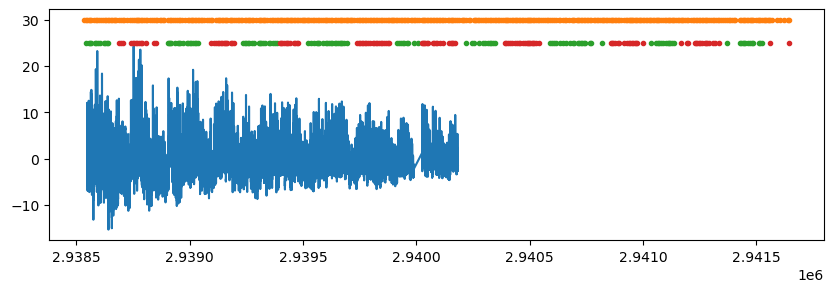

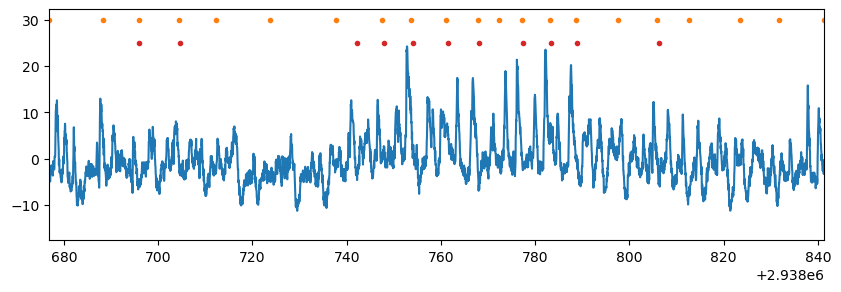

In [92]:
# Plot check for harp triggers and 560 nm signal in time

# Detrent the signal with a 3rd order polynomial
def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,3)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended

px = 600
detrended_signal = detrend_signal(L_560_F2[:,px-400])

# Calculate deltaF/F for 560 nm signal
dF_F = 100*(detrended_signal-np.mean(detrended_signal))/np.mean(detrended_signal)

plt.figure(figsize=(10,3))
plt.plot(harp_time_405,dF_F)
plt.plot(data['B_GoCueTimeHarp'],30*np.ones(len(data['B_GoCueTimeHarp'])),'.')
plt.plot(data['B_LeftRewardDeliveryTimeHarp'],25*np.ones(len(data['B_LeftRewardDeliveryTimeHarp'])),'.')
plt.plot(data['B_RightRewardDeliveryTimeHarp'],25*np.ones(len(data['B_RightRewardDeliveryTimeHarp'])),'.')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(harp_time_405,dF_F)
plt.plot(data['B_GoCueTime'],30*np.ones(len(data['B_GoCueTime'])),'.')
plt.plot(data['B_LeftRewardDeliveryTime'],25*np.ones(len(data['B_LeftRewardDeliveryTime'])),'.')
plt.plot(data['B_RightRewardDeliveryTime'],25*np.ones(len(data['B_RightRewardDeliveryTime'])),'.')
plt.xlim([data['B_GoCueTime'][20],data['B_GoCueTime'][40]])
plt.show()


In [93]:
# Detrent the hsfp data with a 3rd order polynomial

def detrend_signal(signal):
    x = np.arange(len(signal))
    p = np.polyfit(x,signal,3)
    y = np.polyval(p,x)
    signal_detrended = signal - y + np.mean(signal)
    return signal_detrended

L_405_F1_detrend = np.zeros(np.shape(L_405_F1))
L_405_F2_detrend = np.zeros(np.shape(L_405_F2))
L_445_F1_detrend = np.zeros(np.shape(L_445_F1))
L_445_F2_detrend = np.zeros(np.shape(L_445_F2))
L_473_F1_detrend = np.zeros(np.shape(L_473_F1))
L_473_F2_detrend = np.zeros(np.shape(L_473_F2))
L_514_F1_detrend = np.zeros(np.shape(L_514_F1))
L_514_F2_detrend = np.zeros(np.shape(L_514_F2))
L_560_F1_detrend = np.zeros(np.shape(L_560_F1))
L_560_F2_detrend = np.zeros(np.shape(L_560_F2))
for i in range(len(L_560_F2[0,:])):
    L_405_F1_detrend[:,i] = detrend_signal(L_405_F1[:,i])
    L_405_F2_detrend[:,i] = detrend_signal(L_405_F2[:,i])
    L_445_F1_detrend[:,i] = detrend_signal(L_445_F1[:,i])
    L_445_F2_detrend[:,i] = detrend_signal(L_445_F2[:,i])
    L_473_F1_detrend[:,i] = detrend_signal(L_473_F1[:,i])
    L_473_F2_detrend[:,i] = detrend_signal(L_473_F2[:,i])
    L_514_F1_detrend[:,i] = detrend_signal(L_514_F1[:,i])
    L_514_F2_detrend[:,i] = detrend_signal(L_514_F2[:,i])
    L_560_F1_detrend[:,i] = detrend_signal(L_560_F1[:,i])
    L_560_F2_detrend[:,i] = detrend_signal(L_560_F2[:,i])

In [ ]:
# Create cue triggered plots of all trials combined

cueTrigger = data['B_GoCueTimeHarp']
cueTrigger = cueTrigger[10:200]
freq = 120/5
timestep = 1/freq
t = np.arange(0,10,timestep)

L_405_F1_cue = np.zeros((2*len(t),len(L_405_F1[0,:]),len(cueTrigger)))
L_405_F2_cue = np.zeros((2*len(t),len(L_405_F2[0,:]),len(cueTrigger)))
L_445_F1_cue = np.zeros((2*len(t),len(L_445_F1[0,:]),len(cueTrigger)))
L_445_F2_cue = np.zeros((2*len(t),len(L_445_F2[0,:]),len(cueTrigger)))
L_473_F1_cue = np.zeros((2*len(t),len(L_473_F1[0,:]),len(cueTrigger)))
L_473_F2_cue = np.zeros((2*len(t),len(L_473_F2[0,:]),len(cueTrigger)))
L_514_F1_cue = np.zeros((2*len(t),len(L_514_F1[0,:]),len(cueTrigger)))
L_514_F2_cue = np.zeros((2*len(t),len(L_514_F2[0,:]),len(cueTrigger)))
L_560_F1_cue = np.zeros((2*len(t),len(L_560_F1[0,:]),len(cueTrigger)))
L_560_F2_cue = np.zeros((2*len(t),len(L_560_F2[0,:]),len(cueTrigger)))
for i in range(len(cueTrigger)):
    idx = np.where((np.abs(harp_time_405 - cueTrigger[i])) == np.min(np.abs(harp_time_405 - cueTrigger[i])))[0][0]
    L_405_F1_cue[:,:,i] = L_405_F1_detrend[idx-len(t):idx+len(t),:]
    L_405_F2_cue[:,:,i] = L_405_F2_detrend[idx-len(t):idx+len(t),:]
    L_445_F1_cue[:,:,i] = L_445_F1_detrend[idx-len(t):idx+len(t),:]
    L_445_F2_cue[:,:,i] = L_445_F2_detrend[idx-len(t):idx+len(t),:]
    L_473_F1_cue[:,:,i] = L_473_F1_detrend[idx-len(t):idx+len(t),:]
    L_473_F2_cue[:,:,i] = L_473_F2_detrend[idx-len(t):idx+len(t),:]
    L_514_F1_cue[:,:,i] = L_514_F1_detrend[idx-len(t):idx+len(t),:]
    L_514_F2_cue[:,:,i] = L_514_F2_detrend[idx-len(t):idx+len(t),:]
    L_560_F1_cue[:,:,i] = L_560_F1_detrend[idx-len(t):idx+len(t),:]
    L_560_F2_cue[:,:,i] = L_560_F2_detrend[idx-len(t):idx+len(t),:]

L_405_F1_mCue = np.mean(L_405_F1_cue,axis=2)
L_405_F2_mCue = np.mean(L_405_F2_cue,axis=2)
L_445_F1_mCue = np.mean(L_445_F1_cue,axis=2)
L_445_F2_mCue = np.mean(L_445_F2_cue,axis=2)
L_473_F1_mCue = np.mean(L_473_F1_cue,axis=2)
L_473_F2_mCue = np.mean(L_473_F2_cue,axis=2)
L_514_F1_mCue = np.mean(L_514_F1_cue,axis=2)
L_514_F2_mCue = np.mean(L_514_F2_cue,axis=2)
L_560_F1_mCue = np.mean(L_560_F1_cue,axis=2)
L_560_F2_mCue = np.mean(L_560_F2_cue,axis=2)



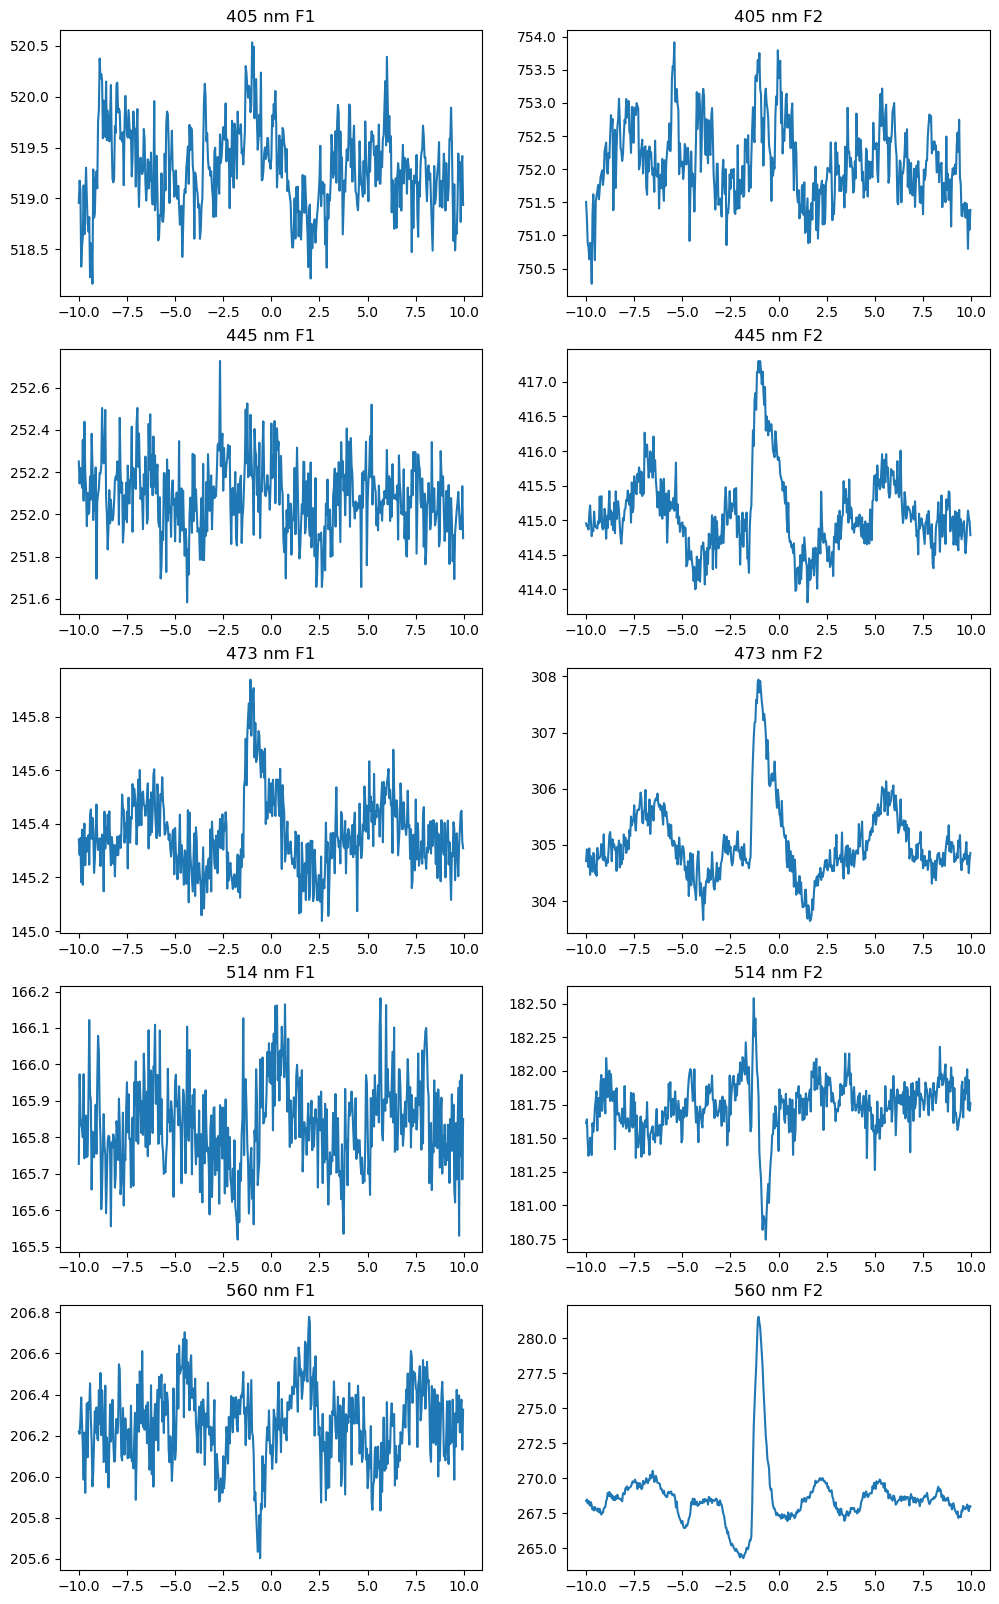

In [150]:
# Create ten subplots of line plots of all trials combined for each laser 

time_axis = np.arange(-len(t),len(t))*timestep
px = [490-400, 500-400, 540-400, 600-400]
plt.figure(figsize=(12,20))
plt.subplot(5,2,1)
plt.plot(time_axis,L_405_F1_mCue[:,px[0]])
plt.title('405 nm F1')
plt.subplot(5,2,2)
plt.plot(time_axis,L_405_F2_mCue[:,px[0]])
plt.title('405 nm F2')
plt.subplot(5,2,3)
plt.plot(time_axis,L_445_F1_mCue[:,px[1]])
plt.title('445 nm F1')
plt.subplot(5,2,4)
plt.plot(time_axis,L_445_F2_mCue[:,px[1]])
plt.title('445 nm F2')
plt.subplot(5,2,5)
plt.plot(time_axis,L_473_F1_mCue[:,px[1]])
plt.title('473 nm F1')
plt.subplot(5,2,6)
plt.plot(time_axis,L_473_F2_mCue[:,px[1]])
plt.title('473 nm F2')
plt.subplot(5,2,7)
plt.plot(time_axis,L_514_F1_mCue[:,px[2]])
plt.title('514 nm F1')
plt.subplot(5,2,8)
plt.plot(time_axis,L_514_F2_mCue[:,px[2]])
plt.title('514 nm F2')
plt.subplot(5,2,9)
plt.plot(time_axis,L_560_F1_mCue[:,px[3]])
plt.title('560 nm F1')
plt.subplot(5,2,10)
plt.plot(time_axis,L_560_F2_mCue[:,px[3]])
plt.title('560 nm F2')
plt.show()


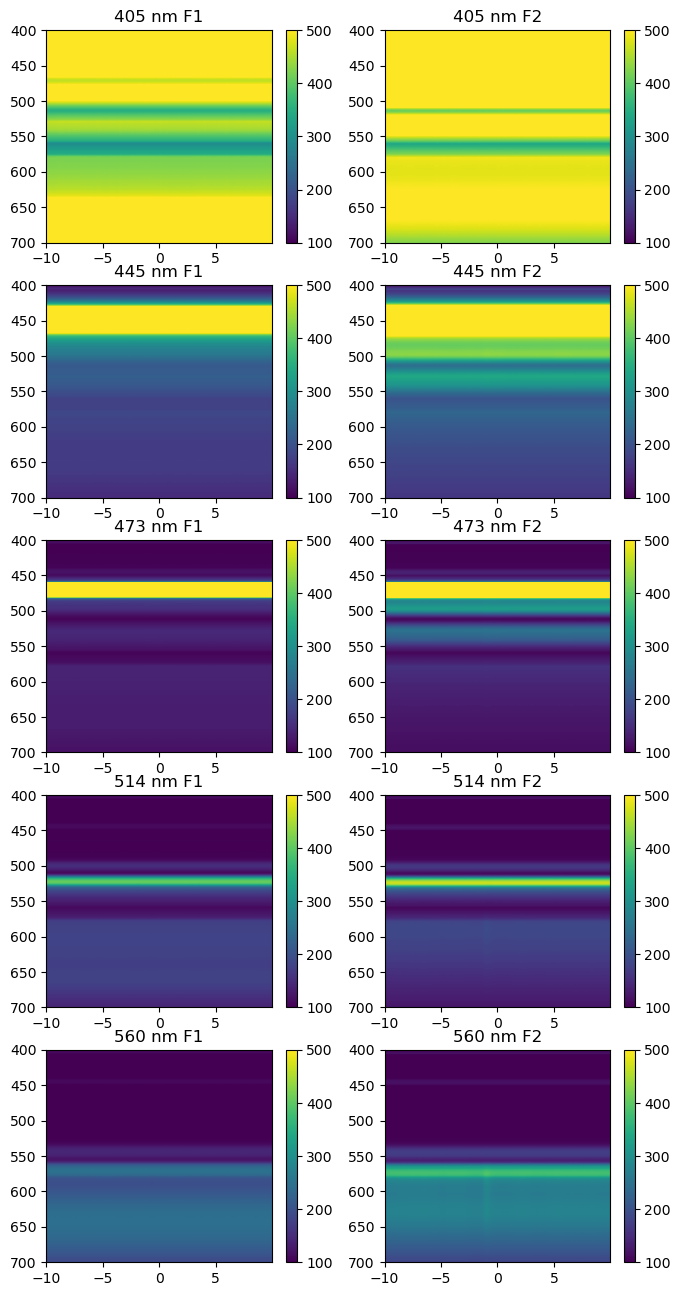

In [144]:
time_axis = np.arange(-len(t),len(t))*timestep

# Create ten spectrogram subplots for each laser line
plt.figure(figsize=(8,16))
plt.subplot(5,2,1)
plt.imshow(np.transpose(L_405_F1_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('405 nm F1')
plt.subplot(5,2,2)
plt.imshow(np.transpose(L_405_F2_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('405 nm F2')
plt.subplot(5,2,3)
plt.imshow(np.transpose(L_445_F1_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('445 nm F1')
plt.subplot(5,2,4)
plt.imshow(np.transpose(L_445_F2_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('445 nm F2')
plt.subplot(5,2,5)
plt.imshow(np.transpose(L_473_F1_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('473 nm F1')
plt.subplot(5,2,6)
plt.imshow(np.transpose(L_473_F2_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('473 nm F2')
plt.subplot(5,2,7)
plt.imshow(np.transpose(L_514_F1_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('514 nm F1')
plt.subplot(5,2,8)
plt.imshow(np.transpose(L_514_F2_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('514 nm F2')
plt.subplot(5,2,9)
plt.imshow(np.transpose(L_560_F1_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('560 nm F1')
plt.subplot(5,2,10)
plt.imshow(np.transpose(L_560_F2_mCue),aspect='auto',extent=[time_axis[0],time_axis[-1],700,400],clim=[100,500])
plt.colorbar()
plt.title('560 nm F2')
plt.show()



In [ ]:
# Seperate trials into rewarded and unrewarded trials and align to choice/reward

